In [1]:
import re
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
%matplotlib inline

rootdir = '/Users/lguillain/Documents/EPFL2018/Semester-Project/papers-import'

## loading content of txt files..

In [2]:
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    source.append(subdir[len(rootdir):])
                except:
                    name, message, content = sys.exc_info()
                    print(message)

## extracting the reference function from the text

One attempt was to use special splitting:

In [3]:
#Example of extraction
t = 'Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.\nAbrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),'
re.split(r'(?<=\.)\n', t)

['Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.',
 'Abrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),']

In [4]:
#dealing with links at the end
t =  'dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083\nEdelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning'
re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',t)

['dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083',
 None,
 None,
 'Edelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning']

#### The issue is that it undersplits, so we it's better to just use \n 

In [5]:
def ref_extraction(text, extract=False):
    """extracts refrerence section: works well on well formated documents"""
    mention = text.rfind("\nReferences")
    if mention == -1:
        mention = text.lower().rfind(" references")
    if mention == -1:
        mention =  text.lower().rfind("reference")
    #get reference section, account for different spelling
    acknowledgements = max(text.lower().find("acknowledgements"), text.lower().find('acknowledgments'))
    
    #handle case that acknowlege ments are before references
    if acknowledgements < mention:
        acknowledgements = -1
    ref = text[mention+len("references"):acknowledgements]
    
    #references = re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',ref)
    references = re.split(r'\n', ref)
    
    ref = [r for r in references if r and len(r) > 3 and not re.match(r'(CSCL|ICLS) \d{4} Proceedings|© ISLS', r)]
    if extract:
        print(text[mention+len("references"):acknowledgements])
        print(references)
    return ref

In [6]:
references = []
for i, content in enumerate(contents):
    references.append((ref_extraction(content)))

In [7]:
print('Number of pdf documents : ', len(contents))
print('Number of documents for which we have an extracted reference section: ', len(references))

Number of pdf documents :  428
Number of documents for which we have an extracted reference section:  428


# looking into regex to check if valid:

One way we can know a line was split early is if it starts with lowercase letter or with a number

This is old code that was used at some point but is not no longer used 

In [8]:
def match_url(sentence):
    return re.search('http(s)?\:\/\/[\S]*$', sentence) or re.search(r'doi\:[\S\/\*]*$', sentence)

def match_url_beginning(sentence):
    return re.search('^http(s)?\:\/\/[\S]*$', sentence) or re.search(r'^doi\:[\S\/\*]*$', sentence)

def show_issue(issues, condition):
    for issue in issues:
        if condition(issue):
            print(issue)

Central approach is to move sentences up until they are part of a string that contains a citation year, which usually is at the beginning of a string in an APA reference 

In [9]:
def contains_citation_beginning(sentence):

    ##Check for mention of publication date,
    #do it this way to not allow for ICLS 2015 string to be counted
    months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
    publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ \d]*'+months+'\)'
    #sometimes two years are mentioned, we use this regex to parse them
    match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    #these regex account for special strings used in the references
    match_press = r'[\w\ \. \,\&\(\)\-\'\…]*\(in press\)'
    match_forth = r'[\S\s]*\(forthcoming\)'
    match_accepted = r'[\S\s]*\(accepted\)'
    match_submitted = r'[\S\s]*\(submitted\)'
    match_underreview = r'[\S\s]*\(under review\)'
    sentence = sentence.lower()
        
    year = re.search(publication_year, sentence) or  re.search(match_bad_year, sentence)
    
    return  year or \
            re.match(match_press, sentence) or re.match(match_forth, sentence) or\
            re.match(match_accepted, sentence) or re.match(match_submitted, sentence) or\
            re.match(match_underreview, sentence)

Example of parsing working:

In [10]:
sentence = 'Xing, W., Kim, S., & Goggins, S. (2015/1994). Modeling performance in asynchronous CSCL: an exploration of social ability, collective efficacy and social interaction. Exploring the Material Conditions of Learning: Proceedings of the Computer Supported Collaborative Learning (CSCL 2015), International Society of'
sentence_2 = 'Engeström, Y. (1987/2014) Learning by expanding: An activity-theoretical approach to developmental research (2nd ed.). New York, NY: Cambridge University Press.'

months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ ]*'+months+'\)'


match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'

month = re.search(publication_year, sentence.lower())
conference =  re.search(match_bad_year, sentence_2)
    
conference, month

(<re.Match object; span=(14, 25), match='(1987/2014)'>, None)

In [11]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_up(issues, condition=lambda x: re.match('^[\d\(\.\&\ ]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = []
    j = 0
    
    for i, sentence in enumerate(issues):
        if i != 0 and condition(sentence):
            patchwork[j-1] += ' ' + sentence
            #print(sentence)
        else:
            j +=1
            patchwork.append(sentence)
    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [12]:
#iteration 1: move up strings that start in number or with (
ref_1 = [moving_up(r) for r in references]
#iteration 2: move up string starting with "Proceedings"
ref_2 = [moving_up(r, lambda x: re.match('^Proceedings', x)) for r in ref_1]

In [13]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_down(issues, condition=lambda x: re.match('^[\d\(\.]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = issues.copy()
    j = 0
    
    for i, sentence in enumerate(issues):
        if condition(sentence) and i+1 < len(issues):
            patchwork[i] = sentence + ' ' + patchwork[i+1]
            patchwork[i+1] = ''

    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [14]:
cutoff_name = r'^[A-Z]+\.\ ?'
text = 'G. bsdjhvshjvf(1220)'
re.match(cutoff_name, text)

<re.Match object; span=(0, 3), match='G. '>

In [15]:
text = 'Walther, J. B., & Parks, M. R. (2002). Cues filtered out, cues filter in: computer mediated communication and'
words_at_end = r'\ [a-zA-Z]*$'
re.search(words_at_end, text)

<re.Match object; span=(105, 109), match=' and'>

In [16]:
#move up is name is cut off (for instance, sentence starts with C. ....)
ref_3 = [moving_up(r, lambda x: re.match(cutoff_name, x)) for r in ref_2]

For references we might cut off the year from the authors. In that case we need to change strategy and move the one that is below up if the upper string satisfies the condition

In [17]:
def match_author(authors):
    regex = r'(([\w\-]*[\,\&] [A-Z\.\ ]+[\&\,]?)*$)'
    USA = r'([A-Z]{2,})'
    return not re.search(USA, authors) and re.match(regex, authors)

In [18]:
sentence = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'
match_author(sentence).group(0)

'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'

In [19]:
ref_4 = [moving_down(r, lambda x: match_author(x)) for r in ref_3]

#pivoting up around strings containing citation
ref_5 = [moving_up(r, lambda x: not contains_citation_beginning(x)) for r in ref_4]
#if ends in word
ref_6 = [moving_down(r, lambda x: re.search(words_at_end, x)) for r in ref_5]

Add the reference isnto dataframe, associating the source text to it:

In [20]:
references_df = pd.DataFrame([(f, source[i]) for i, flat in enumerate(ref_6) for f in flat], columns=['ref', 'file'])

We use length and initial of the reference to preform a sanity check:

In [21]:
references_df['length'] = references_df.ref.map(lambda x: len(x))
references_df['initial'] = references_df.ref.map(lambda x: x[0])

count     8649.000000
mean       202.215863
std        891.650973
min         31.000000
25%        138.000000
50%        180.000000
75%        219.000000
max      74737.000000
Name: length, dtype: float64

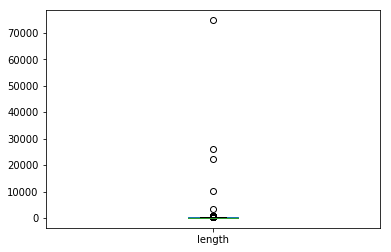

In [22]:
references_df.length.plot(kind='box')
references_df.length.describe()

U    21
Q     7
p     3
Ö     3
Ç     2
b     2
e     2
r     1
h     1
[     1
a     1
f     1
Å     1
n     1
Ž     1
Name: initial, dtype: int64

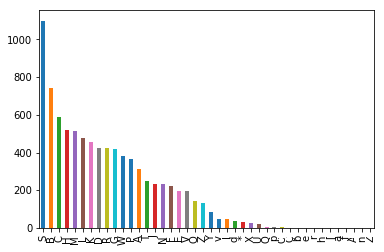

In [23]:
references_df.initial.value_counts().plot(kind='bar')
references_df.initial.value_counts().tail(15)

In [24]:
#short references are fine
references_df[references_df.length < 40]

,ref,file,length,initial
4175,"Wilensky, U. (1999). {NetLogo}.",/import2016short/106,31,W
6969,"Wilensky, U. (1999). {NetLogo}.",/import2017/9,31,W


In [25]:
#also correctly parsed i, e are fine, a are not too bad, leave it
#only very few references are incorrect if they start by lowercase. we accept this
#b is correct
references_df[references_df['initial'] == 'b']

,ref,file,length,initial
2845,"boyd, d. (2009). Why Youth (Heart) Social Netw...",/import2015full/285,110,b
5802,"boyd, d. (2009). Why Youth (Heart) Social Netw...",/import2015short/285,110,b


Remove overly long references are they are due to badly parsed pdfs:

In [26]:
references_df = references_df[(references_df.length < 1000)]

In [27]:
print('We can parse references from {} documents.'.format(references_df.file.value_counts().shape[0]))

We can parse references from 420 documents.


Example reference:

In [28]:
references_df[references_df.length < 200].sample(5).ref.tolist()

['Schunk, D. H., & Zimmerman, B. J. (2008). Motivation and self-regulated learning: Theory, research, and applications. Taylor & Francis.',
 'Scardamalia, M., & Bereiter, C. (2006). Knowledge building: Theory, pedagogy, and technology. In K. Sawyer (Ed.), Cambridge Handbook of the Learning Sciences (pp. 97-118). New York: Cambridge Press.',
 'Gu, X., Shao, Y., Guo, X., & Lim, C. P. (2015). Designing a role structure to engage students in computersupported collaborative learning. Internet and Higher Education, 24, 13-20.',
 'Lasry, N., Mazur, E., & Watkins, J. (2008). Peer instruction: From Harvard to the two-year college. American Journal of Physics, 76(11), 1066-1069.',
 'Cuban, L. (2001). Oversold and Underused: Computers in the Classroom. Cambridge, MA: Harvard University Press.']

# Approach to get names from references:

For APA style it is easy to extract the year and author of the cited reference
- we could look at from when the reference cited is, who is in it

Need to look at efficient way to check name validity:
think spanish, irish names

In [29]:
def get_authors(sentence, debug = False):
    regex = r'[\S\s]*\((18|19|20)\d{2}[\,\ \w\d]*\)'
    if re.search(old_match, sentence):
        s = re.findall(regex, sentence)[0]
        if len(s) > 9:
            return (s)
    elif debug:
        return '#'+sentence
    
    return np.nan



def get_authors_month(sentence, debug = False):
    regex = r'[\S\s]*\([\,\ \w\d\-]*(18|19|20)\d{2}[\,\ \w\d\-]*\)'
    match_bad_year = r'[\S\s]*\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    match_press = r'[\S\s]*\((i|I)n press\)'
    match_forth = r'[\S\s]*\((f|F)orthcoming\)'
    match_accepted = r'[\S\s]*\((a|A)ccepted\)'
    match_submitted = r'[\S\s]*\((s|S)ubmitted\)'
    match_underreview = r'[\S\s]*\((u|U)nder review\)'
    
    #sentence = sentence.lower()
    if re.match(regex, sentence):
        s = re.search(regex, sentence).group(0)
        if len(s) > 9:
            return s
    elif re.match(match_bad_year, sentence):
        return re.search(match_bad_year, sentence).group(0)
    elif re.match(match_press, sentence):
        return re.search(match_press, sentence).group(0)
    elif re.match(match_forth, sentence):
        return re.search(match_forth, sentence).group(0)
    elif re.match(match_accepted, sentence):
        return re.search(match_accepted, sentence).group(0)
    elif re.match(match_submitted, sentence):
        return re.search(match_submitted, sentence).group(0)
    elif re.match(match_underreview, sentence):
        return re.search(match_underreview, sentence).group(0)
    
    return np.nan

In [30]:
references_df['ref_parsed'] = references_df.apply(lambda x: get_authors_month(x['ref']), axis=1)

In [31]:
print('Percentage of unparsed references: ', references_df.ref_parsed.isna().sum()/references_df.ref_parsed.shape[0])
print('Number of unparsed references: ', references_df[references_df.ref_parsed.isna()].ref.shape[0])
print('Number of properly parsed references: ', references_df.ref_parsed.shape[0])

Percentage of unparsed references:  0.0005784359093012494
Number of unparsed references:  5
Number of properly parsed references:  8644


Unpased files:

In [32]:
references_df[references_df.ref_parsed.isna()].ref.tolist()

['* References marked with an asterisk indicate studies included in the review (Not a full list of all of the reviewed studies).',
 'Krist, C., Schwarz, C. V., & Reiser, B. J. (manuscript under review). Identifying and supporting crosscutting epistemic heuristics that guide mechanistic reasoning in science learning.',
 '* References marked with an asterisk indicate studies included in the review (Not a full list of all of the reviewed studies).',
 'Aiello, L. M., Barrat, A., Cattuto, C., Ruffo, G., & Schifanella, R. Link Creation and Profile Alignment in the aNobii Social Network. In 2010 IEEE Second International Conference on Social Computing (SocialCom) (pp. 249–256). doi:10.1109/SocialCom.2010.42',
 'Belland, B. R., Walker, A. E., Kim, N., & Lefler, M. (In Press). Synthesizing results from empirical research on computer-based scaffolding in STEM education: A meta-analysis. Review of Educational Research.']

In [33]:
l = ['/import2016full/95',
 '/import2016full/92',
 '/import2016full/93',
 '/import2016full/94',
 '/import2016full/91',
 '/import2016full/96',
 '/import2016full/98',
 '/import2016full/97']
references_df[references_df.file.map(lambda x: x in l)]

,ref,file,length,initial,ref_parsed


In [34]:
ref_counts = references_df.groupby('file').ref_parsed.count()
ref_counts.name = 'counts'
ref_counts.head()

file
/import2015full/105    33
/import2015full/122    33
/import2015full/126    45
/import2015full/136     8
/import2015full/146    23
Name: counts, dtype: int64

In [35]:
ref_counts.describe()

count    420.000000
mean      20.569048
std       10.799430
min        1.000000
25%       13.000000
50%       19.000000
75%       26.000000
max       78.000000
Name: counts, dtype: float64

In [36]:
df = references_df.join(ref_counts, on='file')
df.head()

,ref,file,length,initial,ref_parsed,counts
0,"Abrahamson, D. (2012). Discovery reconceived: ...",/import2016full/61,114,A,"Abrahamson, D. (2012)",47
1,"Abrahamson, D. (2015). The monster in the mach...",/import2016full/61,192,A,"Abrahamson, D. (2015)",47
2,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",/import2016full/61,194,A,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",47
3,"Abrahamson, D., & Sánchez-García, R. (in press...",/import2016full/61,199,A,"Abrahamson, D., & Sánchez-García, R. (in press)",47
4,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",/import2016full/61,212,A,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",47


We see that only papers that are invalid have no citation

In [37]:
df[df.counts == 1]

,ref,file,length,initial,ref_parsed,counts
4034,"Further, we employed Johnson and Norem-Hebeise...",/import2016short/136,214,F,"Further, we employed Johnson and Norem-Hebeise...",1


In [38]:
df[df.counts == 3]

,ref,file,length,initial,ref_parsed,counts
3332,"Bransford, J. D., Brown, A. L., Cocking, R. R....",/import2016short/168,191,B,"Bransford, J. D., Brown, A. L., Cocking, R. R....",3
3333,National Research Council. (2012). A framework...,/import2016short/168,300,N,National Research Council. (2012),3
3334,DC: The National Academies Press. U.S. Departm...,/import2016short/168,193,D,DC: The National Academies Press. U.S. Departm...,3


In [39]:
references_df[references_df.file == '/import2016short/136']

,ref,file,length,initial,ref_parsed
4034,"Further, we employed Johnson and Norem-Hebeise...",/import2016short/136,214,F,"Further, we employed Johnson and Norem-Hebeise..."


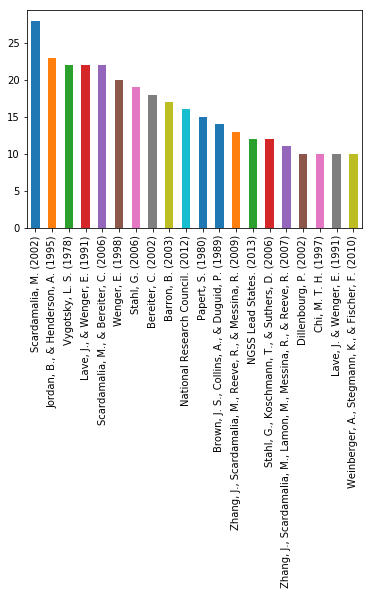

In [40]:
references_df.ref_parsed.value_counts().head(20).plot(kind='bar')

# extracting information for individual references:
## Extracting the year of publication:

In [41]:
years = r'\([\w\d\,\ \.]*(18|19|20)\d{2}[\,\ \w\d]*\)'
match_press = r'\(in press\)'
def extract_year(x):
    year = re.search(years, x)
    if re.search(match_press, x):
        return 2018
    if year:
        year = year.group(0)
        year = re.findall('\d{4}', year)
        return int(year[0])
    else:
        return np.nan

In [42]:
references_df.loc[~references_df.ref_parsed.isna(),'year'] = references_df[~references_df.ref_parsed.isna()].ref_parsed.map(extract_year)

In [43]:
references_df[references_df.year.isna()].shape

(35, 6)

In [44]:
references_df.year.describe()

count    8609.000000
mean     2005.188872
std        10.104455
min      1887.000000
25%      2001.000000
50%      2008.000000
75%      2012.000000
max      2018.000000
Name: year, dtype: float64

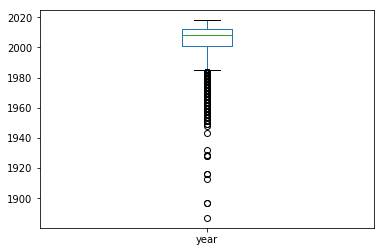

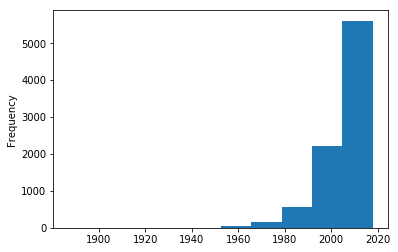

In [45]:
references_df.year.plot(kind='box')
plt.show()
references_df.year.plot(kind='hist')

In [46]:
references_df.to_csv('References.csv')

## Look at individual authors:

For now we look only the the authors that come up in any citation in the paper. So we do not care about order or the specific reference they are associated with:

We again use a regex to extract neighbours

In [47]:
authors = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D., Scheintaub, H., Klopfer, E.'

In [48]:
re.findall(r'([A-Z][^\W\d_\-]*\,?\&? [A-Z]\.\,?)', authors)

['Yoon, S.,',
 'Anderson, E.,',
 'Evans, C.,',
 'Park, M.,',
 'Sheldon, J.,',
 'Schoenfeld, I.,',
 'Wendel, D.,',
 'Scheintaub, H.,',
 'Klopfer, E.']

A change of local seems to allow for better parsing!

In [49]:
import locale
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

In [50]:
regex = r'([\w\-]*[\,] [A-Z\.\ ]+[\&\,]?)'

In [51]:
authors = 'Abrahamson, D., Snüàchez-Gärca, R. S. ,'
re.findall(regex, authors, re.U)

['Abrahamson, D.,', 'Snüàchez-Gärca, R. S. ,']

In [52]:
#extract authors and clean strings a bit
authors = references_df[~references_df.ref_parsed.isna()]\
.ref_parsed.map(lambda x: re.findall(regex, x) ).tolist()
authors = [ [a.replace(',', '').replace('&', '').rstrip() for a in l] for l in authors ]

In [53]:
proto_frame = list(zip(authors, references_df[~references_df.ref_parsed.isna()].file.tolist()))

In [54]:
#extract authors!
authors_frame = pd.DataFrame([(i, index) for (l, index ) in proto_frame for i in l], columns=['author', 'file'])

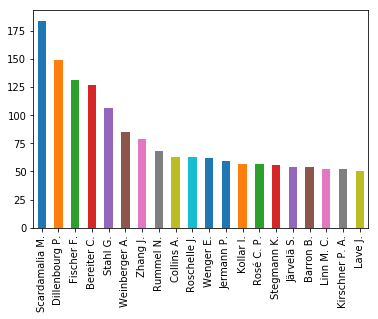

In [55]:
authors_frame.author.value_counts().head(20).plot(kind='bar')

In [56]:
authors_frame.author.value_counts().head(10)

Scardamalia M.    184
Dillenbourg P.    149
Fischer F.        131
Bereiter C.       127
Stahl G.          106
Weinberger A.      85
Zhang J.           79
Rummel N.          68
Collins A.         63
Roschelle J.       63
Name: author, dtype: int64

## Trying to extract the conference

In [57]:
references_df[references_df.ref.map(lambda x: 'CHI' in x)].shape

(47, 6)

In [80]:
text = references_df.sample().ref.item()
re.split(r'\. (?=[A-Z][A-Za-z])', text)

['Rogers, Y., Price, S., Randell, C., Fraser, D. S., Weal, M., & Fitzpatrick, G. (2005)',
 'Ubi-learning integrates indoor and outdoor experiences',
 'Communications of the ACM, 48(1), 55–59.']

In [59]:
references_df[references_df.ref.map(lambda x: 'CHI' in x)].sample(4).ref.tolist()

['Schneider, B. (2014). The Perceptual Benefits of a Tangible Interface Decrease with Users’ Expertise. In CHI ’14 Ext. Abstracts on Human Factors in Computing Systems (963–968). New York, NY, USA: ACM.',
 'Sobel, K., Bhattacharya, A., Hiniker, A., Lee, J.H., Kientz, J., & Yip, J.C. (2017). “It wasn\'t really about the Pokémon": Understanding families\' experiences with a location-based mobile game. In Proceedings of SIGCHI Human Factors in Computing Systems (CHI 2017). New York, NY: ACM.',
 'Smith, B. K., & Reiser, B. J. (1998). National geographic unplugged: Classroom-centered design of interactive nature films. Paper presented at the Proceedings of the SIGCHI Conference on Human Factors in Computing Systems, Los Angeles, California, USA.',
 'Lui, M., Kuhn, A., Acosta, A., Quintana, C., & Slotta, J. D. (2014). Supporting learners in collecting and exploring data from immersive simulations in collective inquiry. Proceedings of ACM SIGCHI Conference on Human Factors in Computing System

In [60]:
references_df[references_df.ref.map(lambda x: 'ICLS' in x)].shape

(56, 6)

In [61]:
text= '/hdfk/2017/r8475'
re.search('\d{3}(0|2|4|6|8)', text)

In [62]:
references_df['conference'] = references_df.file.map(lambda x: 'ICLS' if re.search('\d{3}(0|2|4|6|8)', x) else 'CSCL')

In [63]:
references_df[references_df.ref.map(lambda x: 'CSCL' in x)].conference.value_counts()

CSCL    301
ICLS     72
Name: conference, dtype: int64

In [64]:
references_df[references_df.ref.map(lambda x: 'ICLS' in x)].conference.value_counts()

CSCL    43
ICLS    13
Name: conference, dtype: int64

conference
CSCL    AxesSubplot(0.125,0.125;0.775x0.755)
ICLS    AxesSubplot(0.125,0.125;0.775x0.755)
Name: counts, dtype: object

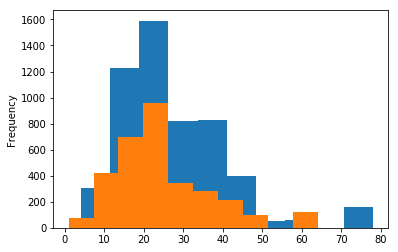

In [65]:
references_df.join(ref_counts, on='file').groupby('conference').counts.plot(kind='hist')

In [70]:
references_df.conference.value_counts()

CSCL    5432
ICLS    3212
Name: conference, dtype: int64

In [73]:
references_df.groupby('file').conference.value_counts()

file                 conference
/import2015full/105  CSCL          33
/import2015full/122  CSCL          33
/import2015full/126  CSCL          45
/import2015full/136  CSCL           8
/import2015full/146  CSCL          23
/import2015full/150  CSCL          20
/import2015full/154  CSCL          21
/import2015full/158  CSCL          39
/import2015full/162  CSCL          47
/import2015full/165  CSCL          34
/import2015full/167  CSCL          34
/import2015full/169  CSCL          35
/import2015full/171  CSCL          21
/import2015full/172  CSCL          17
/import2015full/176  CSCL          22
/import2015full/178  CSCL           9
/import2015full/182  CSCL          14
/import2015full/185  CSCL          19
/import2015full/189  CSCL          28
/import2015full/191  CSCL          29
/import2015full/192  CSCL          24
/import2015full/197  CSCL          21
/import2015full/204  CSCL          16
/import2015full/206  CSCL          24
/import2015full/209  CSCL          78
/import2015full/21

## trying to parse acm authors

We see that there aren't that many, so we won't parse them for not

In [66]:
ACM_authors = []
for i, ref in enumerate(references):
    for sentence in ref:
        s =  re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence)
        if re.match(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence) and not 'http' in s[0].lower() and len(s[0]) > 10:
            #print(sentence)
            print(s[0])
            #apa_authors.append((re.findall(r'.*\(\d{4}\)', sentence)[0], source[i]))

Eisenhardt, K. M. 2000. 
Campbell, L., and B. Campbell. 2009. 
with ScienceKit. Paper presented at CSCL 2015. 
Edmondson, A. C. 1999. 
supports collaboration in a tabletop activity. In Proceedings of GROUP 2014. 
sketching practices in a learning by design task. Paper presented at CSCL 2013. 
Systems, ITS2011. 
Stahl, G., 2006. 
Gilbert, Jane. 2005. 
Dewey, 1913. 
Gee, J. P. 2011. 
Innovating Pedagogy 2012. 
Edmondson, A. C. 1999. 
supports collaboration in a tabletop activity. In Proceedings of GROUP 2014. 
sketching practices in a learning by design task. Paper presented at CSCL 2013. 
Systems, ITS2011. 
Stahl, G., 2006. 
In Advanced Learning Technologies, 2003. 
Milheim, K. 2007. 
Condition of Education 2015. 
In Ubiquitous Virtual Reality, 2009. 
of Oregon, 1968. 
Dillenbourg, P. 1999. 
Halverson, E.R. and Sheridan, K. 2014. 
Klahr, D. and Nigam, M. 2004. 
supports collaboration in a tabletop activity. In Proceedings of GROUP 2014. 
the Proceedings of International Conference of Le

In [67]:
re.match(r'(.*\d{4}\. )', "https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.")

<re.Match object; span=(0, 55), match='https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=>

In [68]:
m = re.match(r'.*\d{4}\. ', 'https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.')

In [69]:
re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', 'McKenzie, W., and Murphy, D. 2000. “I hope this goes somewhere”: Evaluation of an on')

['McKenzie, W., and Murphy, D. 2000. ']